In [5]:
import numpy as np
import pandas as pd
import json
import folium
import requests
import matplotlib.pyplot as plt
import types
import pandas as pd
import warnings

pd.set_option("display.float_format", lambda x: "%.2f" % x)
warnings.filterwarnings(action="ignore")

### Reading US COUNTY COVID-19 Data

In [6]:
# The code was removed by Watson Studio for sharing.

,date,county,state,fips,state_fips,county_fips,cases,deaths,new_day_cases,new_day_deaths,cases_per_capita_100k,deaths_per_capita_100k,new_day_cases_per_capita_100k,new_day_deaths_per_capita_100k,county_pop_2019_est,pop_per_sq_mile_2010
0,2020-01-21,Snohomish,Washington,53061,53,61,1,0,0.00,0.00,0.12,0.00,0.00,0.00,822083.00,341.80
1,2020-01-22,Snohomish,Washington,53061,53,61,1,0,0.00,0.00,0.12,0.00,0.00,0.00,822083.00,341.80
2,2020-01-23,Snohomish,Washington,53061,53,61,1,0,0.00,0.00,0.12,0.00,0.00,0.00,822083.00,341.80
3,2020-01-24,Cook,Illinois,17031,17,31,1,0,0.00,0.00,0.02,0.00,0.00,0.00,5150233.00,5495.10
4,2020-01-24,Snohomish,Washington,53061,53,61,1,0,0.00,0.00,0.12,0.00,0.00,0.00,822083.00,341.80


### Converting date string to date type

In [7]:
covid_df['date'] = pd.to_datetime(covid_df['date'])

### Describing COVID-19 data

In [8]:
covid_df.describe()

,fips,state_fips,county_fips,cases,deaths,new_day_cases,new_day_deaths,cases_per_capita_100k,deaths_per_capita_100k,new_day_cases_per_capita_100k,new_day_deaths_per_capita_100k,county_pop_2019_est,pop_per_sq_mile_2010
count,177767.00,177767.00,177767.00,177767.00,177767.00,177767.00,177767.00,177767.00,177767.00,177767.00,177767.00,177767.00,177767.00
mean,30017.57,29.92,100.87,319.51,17.80,9.42,0.56,145.49,5.89,5.02,0.21,143453.68,304.29
std,15365.83,15.35,106.28,3280.49,298.44,82.87,8.71,367.76,17.10,29.58,1.24,463700.53,1784.59
min,1001.00,1.00,1.00,1.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,625.00,0.00
25%,18067.00,18.00,33.00,4.00,0.00,0.00,0.00,18.28,0.00,0.00,0.00,15911.00,25.50
50%,29045.00,29.00,77.00,16.00,0.00,0.00,0.00,49.50,0.00,0.00,0.00,35529.00,58.50
75%,45033.00,45.00,131.00,75.00,2.00,3.00,0.00,130.11,4.26,4.28,0.00,98498.00,161.60
max,56043.00,56.00,840.00,204111.00,20795.00,8021.00,1221.00,12344.91,309.83,7949.31,106.42,10039107.00,69467.50


### Printing Duration of Data

In [9]:
print('begin: {0}, end: {1}'.format(covid_df.date.min(), covid_df.date.max()))

begin: 2020-01-21 00:00:00, end: 2020-05-26 00:00:00


### Reading Geospatial Data for US counties

In [10]:
body = client_04e417af96274891b2001e136606f42f.get_object(Bucket='ibmcapstoneproject-donotdelete-pr-9jmhti60s34ftn',Key='us_county_pop_and_shps.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

geo_county_df = pd.read_csv(body)
geo_county_df.head()

,state,county,fips,county_pop_2019_est,county_center_lat,county_center_lon,center_point,county_geom
0,Alabama,Autauga,1001,55869.00,32.54,-86.64,POINT (-86.64129633660016 32.53942589757445),POLYGON ((-86.82066986329349 32.34730960076057...
1,Alabama,Baldwin,1003,223234.00,30.74,-87.72,POINT (-87.72479592163093 30.74311980602181),POLYGON ((-87.97308978075395 31.16482251520438...
2,Alabama,Barbour,1005,24686.00,31.88,-85.39,POINT (-85.39237810741868 31.87734308059179),POLYGON ((-85.74337279655801 31.62624052460075...
3,Alabama,Bibb,1007,22394.00,33.00,-87.13,POINT (-87.12752218892099 33.00020707010519),POLYGON ((-87.41985563876936 33.01177307648309...
4,Alabama,Blount,1009,57826.00,33.98,-86.57,POINT (-86.56704692990787 33.98324660367452),POLYGON ((-86.96799449037186 33.86045466926403...


### Joining with Covid data to do analysis

In [11]:
geo_covid_df = pd.merge(covid_df, geo_county_df, how='left', on=['fips', 'county', 'state', 'county_pop_2019_est']).dropna()
geo_covid_df['date2'] = geo_covid_df['date'].astype('str')

### Visualizing Covid Affect in US through visualizations

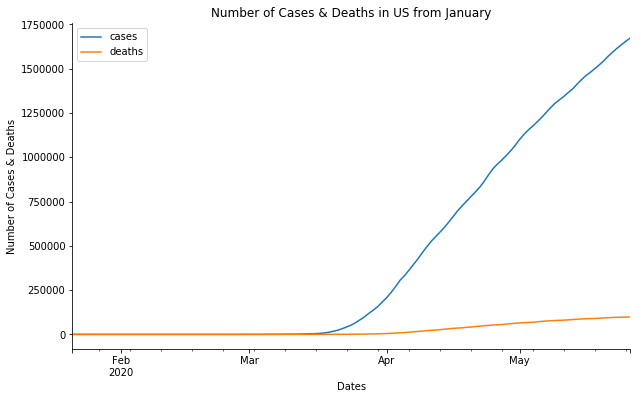

In [12]:
us_df = covid_df.groupby(['date'], as_index=True).sum()
us_df = us_df[['cases', 'deaths']]
us_df['cases'].plot(kind='line', figsize=(10,6), legend=True)
us_df['deaths'].plot(kind='line', figsize=(10,6), legend=True)
plt.title('Number of Cases & Deaths in US from January')
plt.xlabel('Dates')
plt.ylabel('Number of Cases & Deaths')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Which states are the most affected in USA ?
#### To answer this we need to look at two things:  <br>  <br>1. States with most number of cases and   <br>      2. States with most number of deaths

In [13]:
most_affected = covid_df[covid_df['date'] == covid_df.date.max()].reset_index(drop=True)
most_affected = most_affected[['cases', 'deaths','state']]
most_affected = most_affected.groupby(['state'], as_index=False).sum()

In [14]:
us_state_abbrev = us_state_abbrev = {'Alabama': 'AL','Alaska': 'AK','American Samoa': 'AS','Arizona': 'AZ', 'Arkansas': 'AR','California': 'CA',
'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA', 'Guam': 'GU', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Northern Mariana Islands':'MP', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Puerto Rico': 'PR', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virgin Islands': 'VI', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY' }

In [15]:
import urllib.request, json 
with urllib.request.urlopen("https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json") as url:
    state_geo = json.loads(url.read().decode())

In [16]:
temp = most_affected.replace(us_state_abbrev)
m = folium.Map(location=[48.88, -102.13], zoom_start=3.3, tiles='OpenStreetMap', width='52%',
               height='70%', min_zoom=3, max_zoom=4)
# Add the color for the chloropleth:
m.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=temp,
 columns=['state', 'cases'],
 key_on='feature.id',
 fill_color='YlOrRd',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Number of Cases as of May 26, 2020'
)
folium.LayerControl().add_to(m)
m

In [17]:
temp = most_affected.replace(us_state_abbrev)
m = folium.Map(location=[48.88, -102.13], zoom_start=3.3, tiles='OpenStreetMap', width='52%',
               height='70%', min_zoom=3, max_zoom=4)
# Add the color for the chloropleth:
m.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=temp,
 columns=['state', 'deaths'],
 key_on='feature.id',
 fill_color='YlOrRd',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Number of Deaths as of May 26, 2020'
)
folium.LayerControl().add_to(m)
m

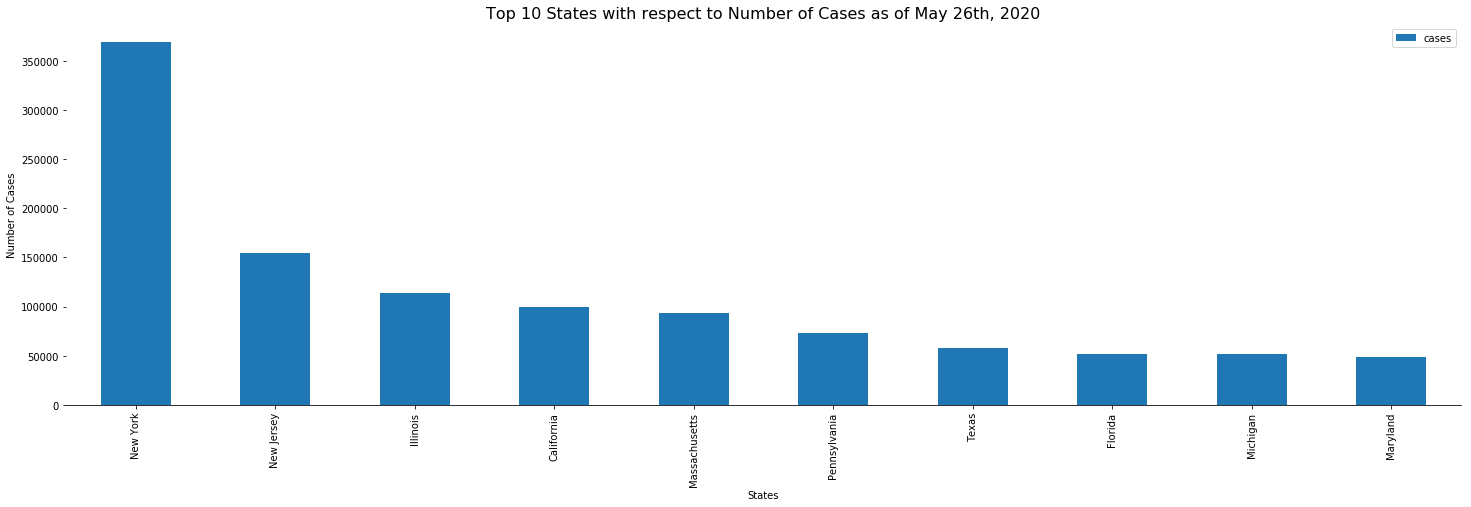

In [18]:
top_10_cases = most_affected[['state', 'cases']].sort_values(by='cases', ascending=False).reset_index(drop=True)
top_cases = top_10_cases.head(10)['state'].values.tolist()
top_10_cases = top_10_cases.head(10).set_index('state', drop=True)
top_10_cases.plot(kind='bar', legend=True, figsize=(25,7))
plt.title('Top 10 States with respect to Number of Cases as of May 26th, 2020', fontsize='16')
plt.xlabel('States')
plt.ylabel('Number of Cases')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

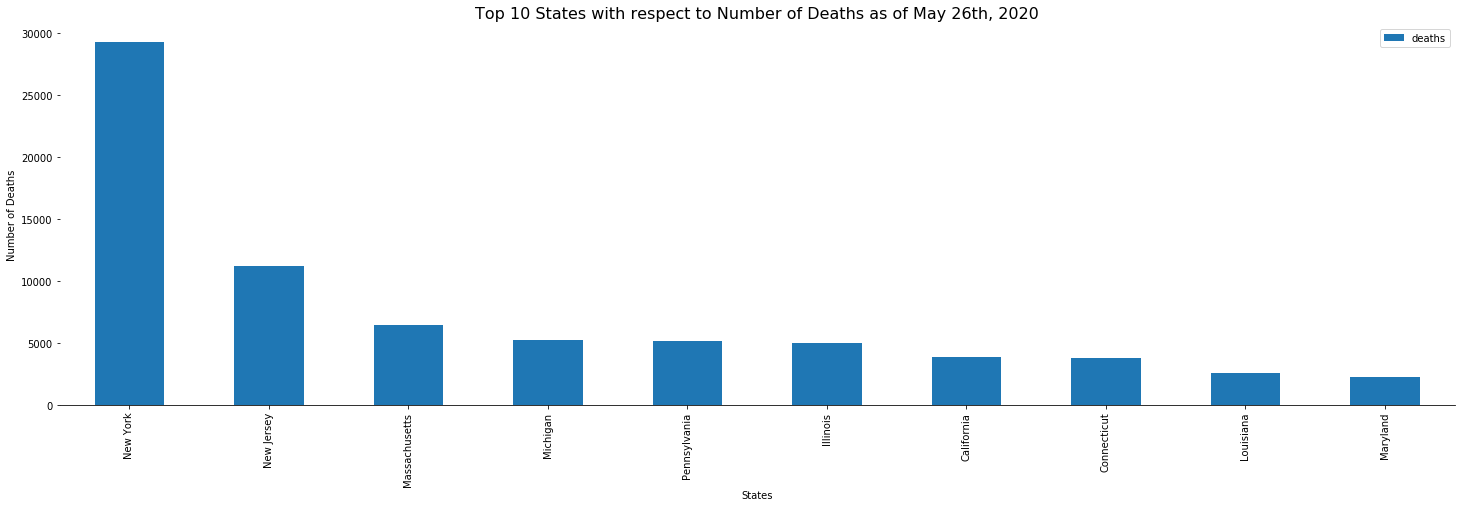

In [19]:
top_10_deaths = most_affected[['state', 'deaths']].sort_values(by='deaths', ascending=False).reset_index(drop=True)
top_deaths = top_10_deaths.head(10)['state'].values.tolist()
top_10_deaths = top_10_deaths.head(10).set_index('state', drop=True)
top_10_deaths.plot(kind='bar', legend=True, figsize=(25,7))
plt.title('Top 10 States with respect to Number of Deaths as of May 26th, 2020', fontsize=16)
plt.xlabel('States')
plt.ylabel('Number of Deaths')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

In [20]:
diff = list(set(top_deaths).difference(set(top_cases)))

In [21]:
print('If you analyze carefully we see that there are two states {} and {} which have less number of cases but more deaths!'.format(diff[0],diff[1]))

If you analyze carefully we see that there are two states Louisiana and Connecticut which have less number of cases but more deaths!


### We will look more into demographics of these two states to analyze if we can find some interesting fact

In [22]:
body = client_04e417af96274891b2001e136606f42f.get_object(Bucket='ibmcapstoneproject-donotdelete-pr-9jmhti60s34ftn',Key='us_county_demographics.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

demographic_df = pd.read_csv(body)
demographic_df.head()

,state_fips,county_fips,state,county,TOT_POP,MALE_PERC,FEMALE_PERC,WHITE_POP_PERC,BLACK_POP_PERC,ASIAN_POP_PERC,...,AGE_OTO4,AGE_5TO14,AGE_15TO24,AGE_25TO34,AGE_35TO44,AGE_45TO54,AGE_55TO64,AGE_65TO74,AGE_75TO84,AGE_84PLUS
0,1,1,Alabama,Autauga County,55601,0.49,0.51,0.78,0.21,0.02,...,3364,7305,6928,7166,7244,7777,7164,4900,2882,871
1,1,3,Alabama,Baldwin County,218022,0.48,0.52,0.89,0.10,0.02,...,11955,26783,24040,24528,26033,28703,31409,26738,13529,4304
2,1,5,Alabama,Barbour County,24881,0.53,0.47,0.50,0.49,0.01,...,1284,2957,2923,3466,2981,3227,3211,2877,1483,472
3,1,7,Alabama,Bibb County,22400,0.53,0.47,0.78,0.22,0.00,...,1285,2497,2573,3327,2952,3179,2897,2174,1153,363
4,1,9,Alabama,Blount County,57840,0.49,0.51,0.97,0.02,0.01,...,3460,7537,6846,6934,7067,7818,7630,6243,3273,1032


In [23]:
demographic_df_diff = demographic_df[demographic_df['state'].isin(diff)].reset_index(drop=True)
demographic_df_diff = demographic_df_diff.drop(columns=['state_fips', 'county_fips', 'county'], axis=1)
demographic_df_diff = demographic_df_diff.groupby(['state'], as_index=False).sum()
demographic_df_diff

,state,TOT_POP,MALE_PERC,FEMALE_PERC,WHITE_POP_PERC,BLACK_POP_PERC,ASIAN_POP_PERC,HISP_POP_PERC,AGE_OTO4,AGE_5TO14,AGE_15TO24,AGE_25TO34,AGE_35TO44,AGE_45TO54,AGE_55TO64,AGE_65TO74,AGE_75TO84,AGE_84PLUS
0,Connecticut,3572665,3.93,4.07,6.96,0.76,0.37,0.99,183134,413908,485020,445390,423336,494951,511805,343570,179680,91871
1,Louisiana,4659978,32.02,31.98,42.10,21.13,0.81,2.40,307019,608925,605321,667182,583526,563306,606266,427946,209437,81050


In [24]:
demographic_df_diff['Young'] = demographic_df_diff[['AGE_OTO4', 'AGE_5TO14', 'AGE_15TO24']].sum(axis=1)
demographic_df_diff['Middle_Age'] = demographic_df_diff[['AGE_25TO34', 'AGE_35TO44', 'AGE_45TO54']].sum(axis=1)
demographic_df_diff['Old_Age'] = demographic_df_diff[['AGE_55TO64', 'AGE_65TO74', 'AGE_75TO84','AGE_84PLUS']].sum(axis=1)
demographic_tr_diff = demographic_df_diff[['state', 'TOT_POP', 'Young', 'Middle_Age', 'Old_Age']]
demographic_tr_diff

,state,TOT_POP,Young,Middle_Age,Old_Age
0,Connecticut,3572665,1082062,1363677,1126926
1,Louisiana,4659978,1521265,1814014,1324699


In [25]:
demographic_tr_diff['Young'] = round((demographic_tr_diff['Young']/demographic_tr_diff['TOT_POP'])*100,2)
demographic_tr_diff['Middle_Age'] = round((demographic_tr_diff['Middle_Age']/demographic_tr_diff['TOT_POP'])*100,2)
demographic_tr_diff['Old_Age'] = round((demographic_tr_diff['Old_Age']/demographic_tr_diff['TOT_POP'])*100,2)
demographic_tr_diff

,state,TOT_POP,Young,Middle_Age,Old_Age
0,Connecticut,3572665,30.29,38.17,31.54
1,Louisiana,4659978,32.65,38.93,28.43


In [26]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

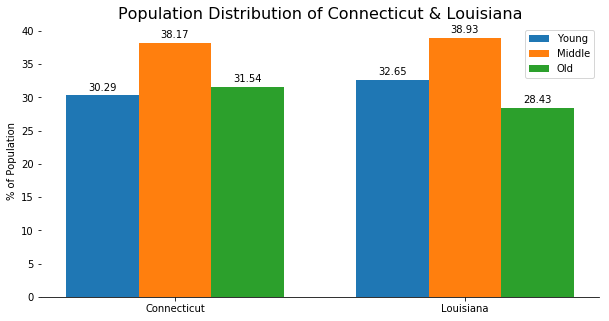

In [27]:
labels = ['Connecticut', 'Louisiana']
young = [demographic_tr_diff.iloc[0]['Young'], demographic_tr_diff.iloc[1]['Young']]
middle = [demographic_tr_diff.iloc[0]['Middle_Age'], demographic_tr_diff.iloc[1]['Middle_Age']]
old = [demographic_tr_diff.iloc[0]['Old_Age'], demographic_tr_diff.iloc[1]['Old_Age']]

x = np.arange(len(labels))

width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width, young, width, label='Young')
rects2 = ax.bar(x , middle, width, label='Middle')
rects3 = ax.bar(x + width, old, width, label='Old')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylabel('% of Population')
ax.set_title('Population Distribution of Connecticut & Louisiana', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(['Connecticut', 'Louisiana'])
ax.legend()

In [28]:
print('It looks like these two states have a very high % of Elderly Population hence, are more prone to death by Coivd-19')

It looks like these two states have a very high % of Elderly Population hence, are more prone to death by Coivd-19


### Now we shall analyse New York: Most effected state and try to find if we can get some safe counties there<br><br>

1. Get Population Distribution
2. Get most effected Counties
3. From FourSquare API get outdoor locations in Least Effected counties so that people can venture out

In [29]:
ny_covid_geo = geo_covid_df[geo_covid_df['state'] == 'New York'].reset_index(drop=True)

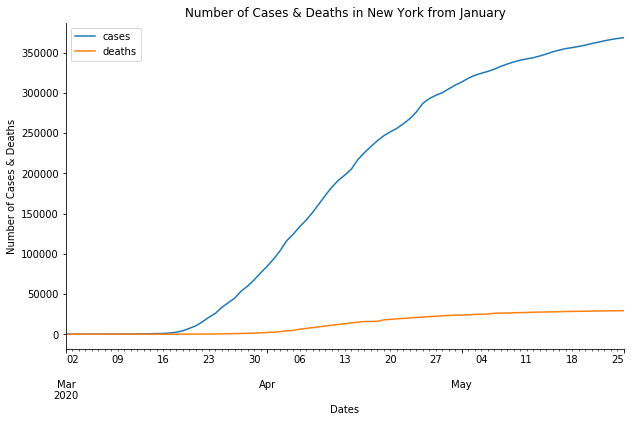

In [30]:
state_level = ny_covid_geo[['date', 'state', 'cases', 'deaths']].groupby(['date'], as_index=True).sum()
state_level = state_level[['cases', 'deaths']]
state_level['cases'].plot(kind='line', figsize=(10,6), legend=True)
state_level['deaths'].plot(kind='line', figsize=(10,6), legend=True)
plt.title('Number of Cases & Deaths in New York from January')
plt.xlabel('Dates')
plt.ylabel('Number of Cases & Deaths')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

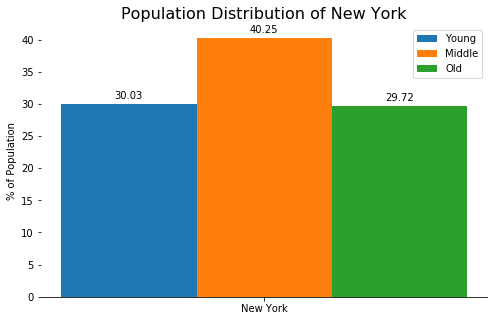

In [31]:
ny_demographic = demographic_df[demographic_df['state'] == 'New York'].reset_index(drop=True)
ny_demographic = ny_demographic.drop(columns=['state_fips', 'county_fips', 'county'], axis=1)
ny_demographic = ny_demographic.groupby(['state'], as_index=False).sum()

ny_demographic['Young'] = ny_demographic[['AGE_OTO4', 'AGE_5TO14', 'AGE_15TO24']].sum(axis=1)
ny_demographic['Middle_Age'] = ny_demographic[['AGE_25TO34', 'AGE_35TO44', 'AGE_45TO54']].sum(axis=1)
ny_demographic['Old_Age'] = ny_demographic[['AGE_55TO64', 'AGE_65TO74', 'AGE_75TO84','AGE_84PLUS']].sum(axis=1)
ny_demographic = ny_demographic[['state', 'TOT_POP', 'Young', 'Middle_Age', 'Old_Age']]

ny_demographic['Young'] = round((ny_demographic['Young']/ny_demographic['TOT_POP'])*100,2)
ny_demographic['Middle_Age'] = round((ny_demographic['Middle_Age']/ny_demographic['TOT_POP'])*100,2)
ny_demographic['Old_Age'] = round((ny_demographic['Old_Age']/ny_demographic['TOT_POP'])*100,2)

labels = ['New York']
young = [ny_demographic.iloc[0]['Young']]
middle = [ny_demographic.iloc[0]['Middle_Age']]
old = [ny_demographic.iloc[0]['Old_Age']]

x = np.arange(len(labels))

width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width, young, width, label='Young')
rects2 = ax.bar(x , middle, width, label='Middle')
rects3 = ax.bar(x + width, old, width, label='Old')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylabel('% of Population')
ax.set_title('Population Distribution of New York', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(['New York'])
ax.legend()

In [32]:
ny_latest = ny_covid_geo[ny_covid_geo.date == ny_covid_geo.date.max()].reset_index(drop=True)

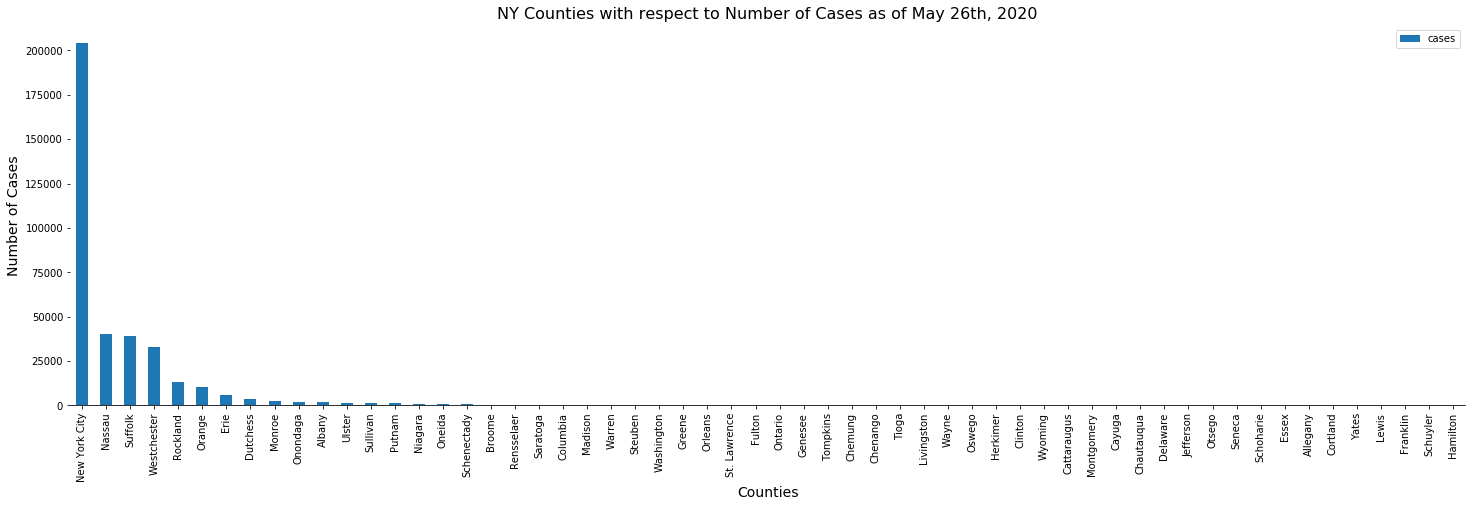

In [33]:
most_cases_counties = ny_latest[['county', 'cases']].sort_values(by='cases', ascending=False).reset_index(drop=True)
most_cases_counties = most_cases_counties.set_index('county', drop=True)
most_cases_counties.plot(kind='bar', legend=True, figsize=(25,7))
plt.title('NY Counties with respect to Number of Cases as of May 26th, 2020', fontsize='16')
plt.xlabel('Counties', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

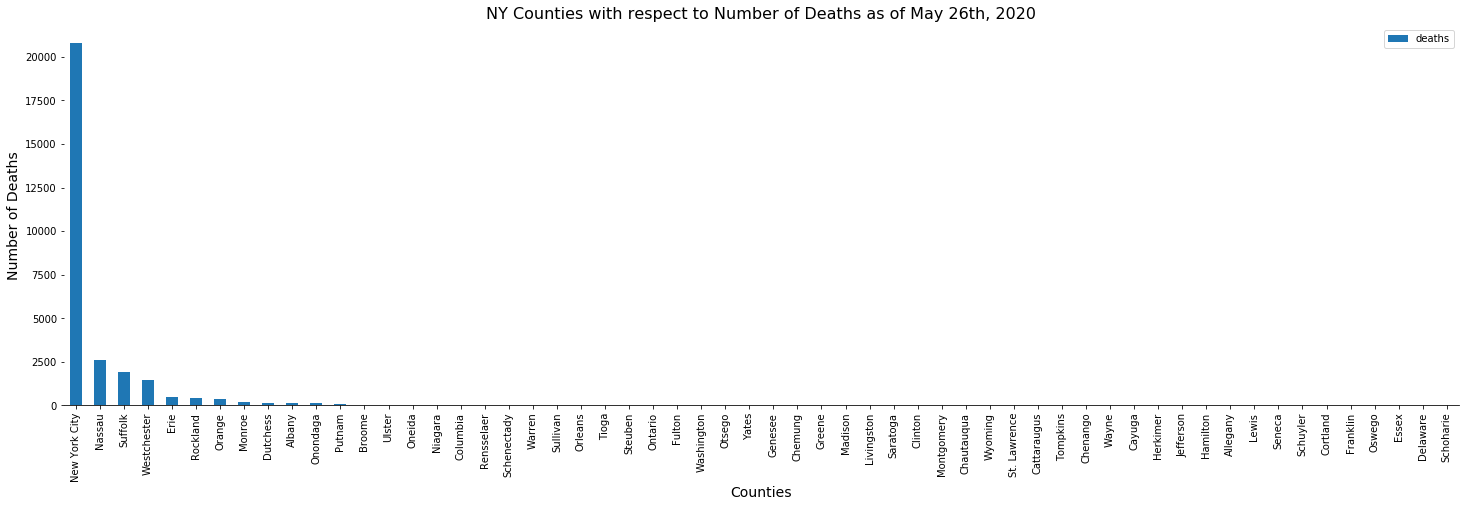

In [34]:
most_deaths_counties = ny_latest[['county', 'deaths']].sort_values(by='deaths', ascending=False).reset_index(drop=True)
most_deaths_counties = most_deaths_counties.set_index('county', drop=True)
most_deaths_counties.plot(kind='bar', legend=True, figsize=(25,7))
plt.title('NY Counties with respect to Number of Deaths as of May 26th, 2020', fontsize='16')
plt.xlabel('Counties', fontsize=14)
plt.ylabel('Number of Deaths', fontsize=14)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

### Analysing this we see that most effected county i.e., New York City county contibuted to this disaster the most!

### We will next check covid trends for top 5 most effected counties in NY to know whether it is safe to get out there

#### Getting Top 5 effected counties in NY

In [35]:
effected_counties = most_cases_counties[:5].index.values.tolist()
effected_counties_df = ny_covid_geo[ny_covid_geo['county'].isin(effected_counties)].reset_index(drop=True)

In [ ]:
def build_combo_chart(df, county_name):
    N = df.shape[0]
    vals = (df['new_day_cases'].values.tolist())
    ind = np.arange(N)
    plt.figure(figsize=(20,10))
    plt.ylim(df.new_day_cases.min(), df.new_day_cases.max())
    plt.bar(ind, vals, color='black', label='New Cases')
    plt.ylabel('Number of New Cases (Shown as Bars)', fontsize=14)
    plt.title('Trend for '+ county_name, fontsize=16)
    plt.xlabel('Day Number since Covid Started', fontsize=14)
    x = np.arange(N)
    y = np.array(df['cases'].values.tolist())
    axes2 = plt.twinx()
    axes2.plot(x, y, color='r', label='Cases')
    axes2.set_ylim(df.cases.min(), df.cases.max())
    axes2.set_ylabel('Total Cases (Shown as Line)', fontsize=14)

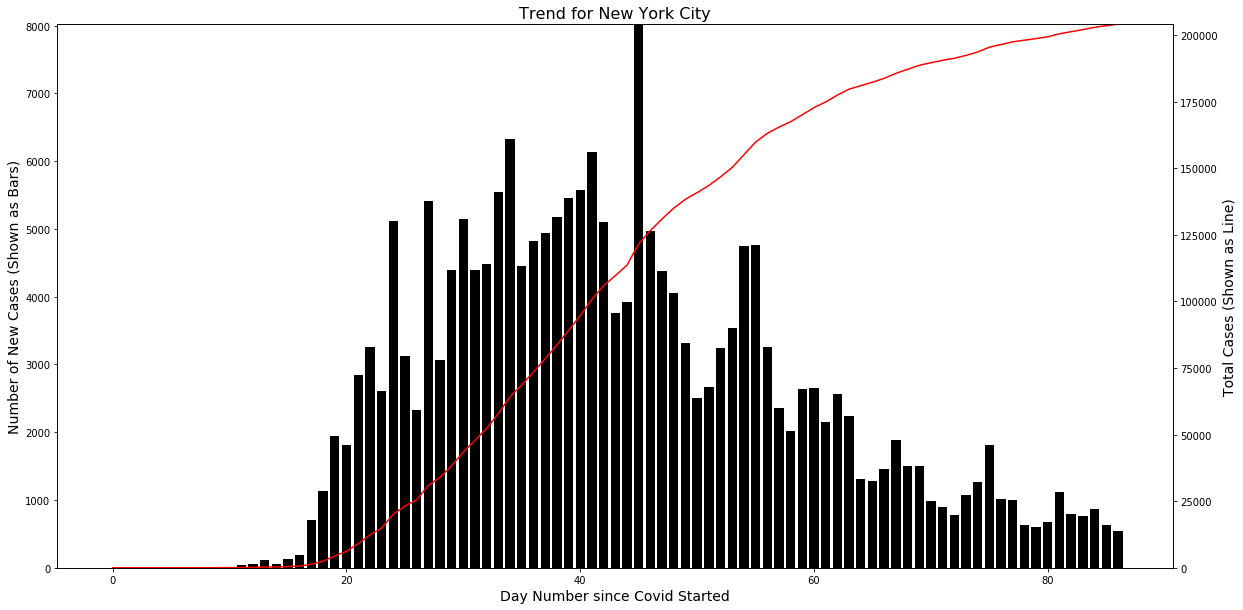

In [37]:
nyc_county = effected_counties_df[effected_counties_df['county'] == 'New York City'].reset_index(drop=True)
nyc_county = nyc_county.sort_values(by='date').reset_index(drop=True)
nyc_county = nyc_county.set_index('date', drop=True)
nyc_county = nyc_county[['cases', 'new_day_cases']]

build_combo_chart(nyc_county, 'New York City')

#### Trend Analysis for New York City County shows that number of new cases being reported have decreased over past 30 days!

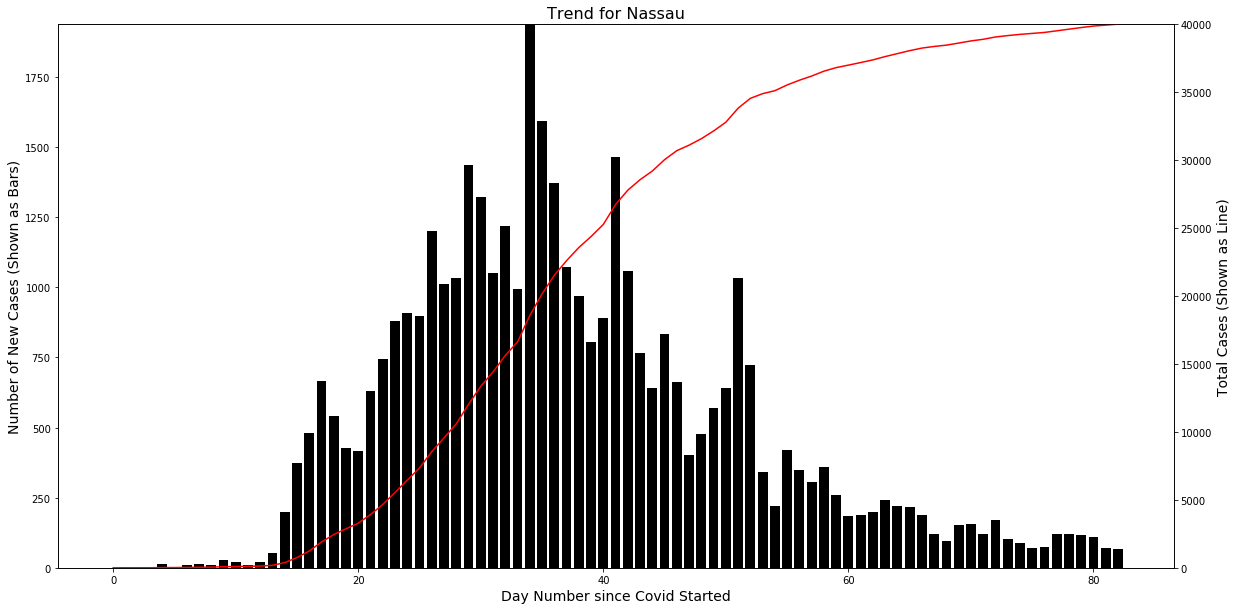

In [38]:
nassau_county = effected_counties_df[effected_counties_df['county'] == 'Nassau'].reset_index(drop=True)
nassau_county = nassau_county.sort_values(by='date').reset_index(drop=True)
nassau_county = nassau_county.set_index('date', drop=True)
nassau_county = nassau_county[['cases', 'new_day_cases']]

build_combo_chart(nassau_county, 'Nassau')

#### Trend Analysis for Nassau County shows that number of new cases being reported have decreased over past 30 days!

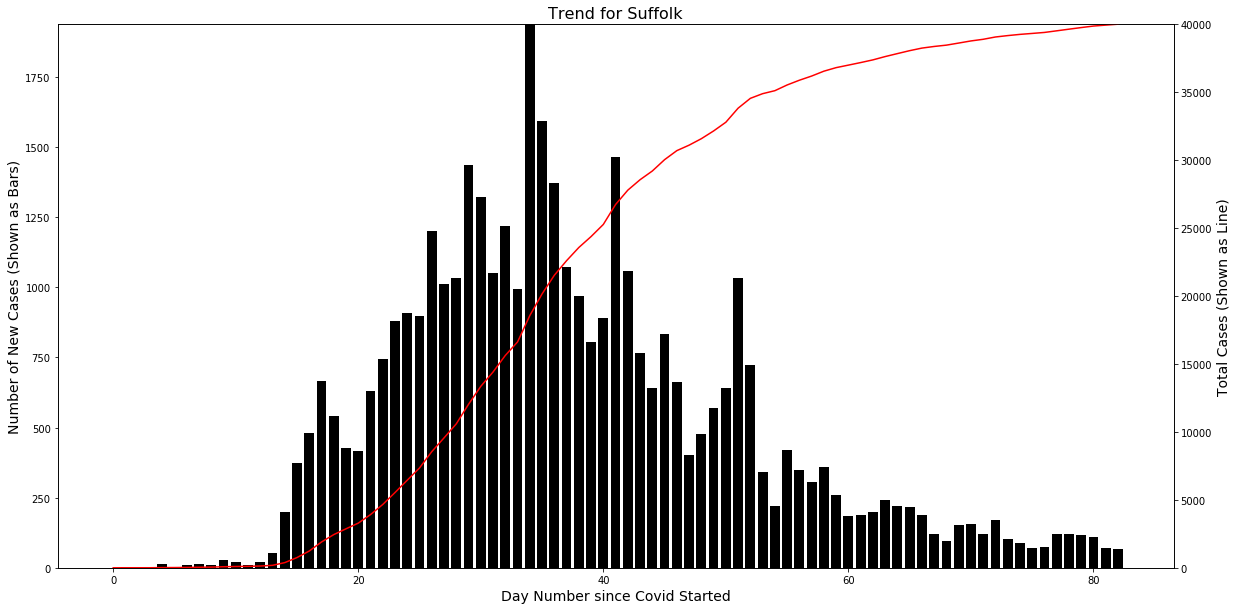

In [39]:
suffolk_county = effected_counties_df[effected_counties_df['county'] == 'Suffolk'].reset_index(drop=True)
suffolk_county = suffolk_county.sort_values(by='date').reset_index(drop=True)
suffolk_county = suffolk_county.set_index('date', drop=True)
suffolk_county = suffolk_county[['cases', 'new_day_cases']]

build_combo_chart(nassau_county, 'Suffolk')

#### Trend Analysis for Suffolk County shows that number of new cases being reported have decreased over past 30 days!

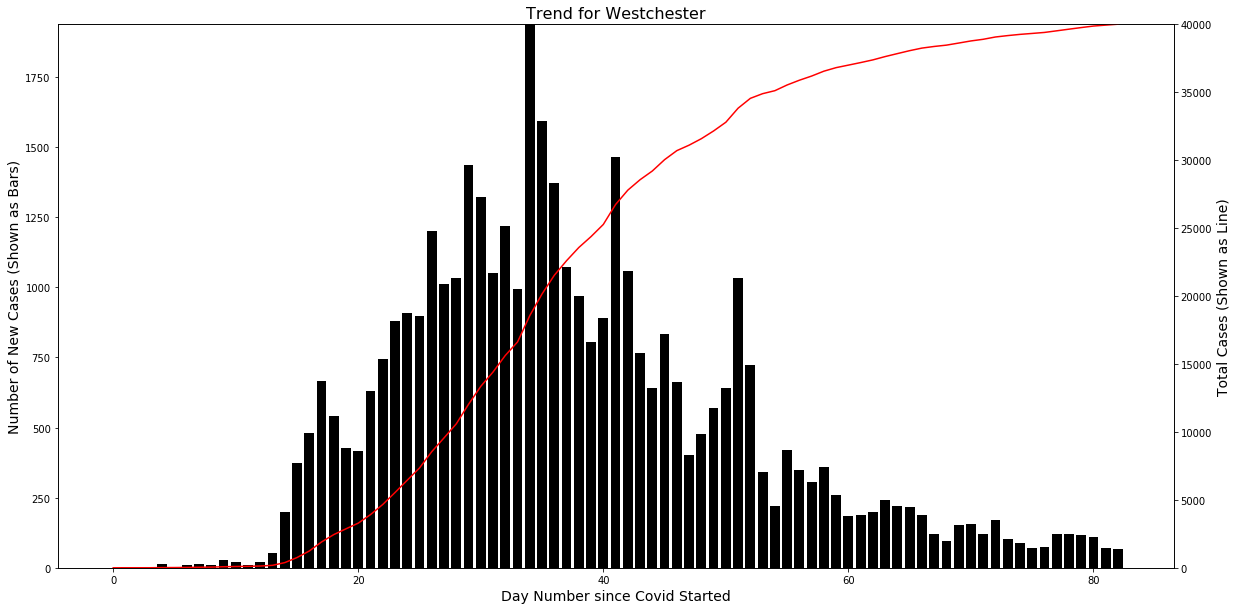

In [40]:
westchester_county = effected_counties_df[effected_counties_df['county'] == 'Westchester'].reset_index(drop=True)
westchester_county = westchester_county.sort_values(by='date').reset_index(drop=True)
westchester_county = westchester_county.set_index('date', drop=True)
westchester_county = westchester_county[['cases', 'new_day_cases']]

build_combo_chart(nassau_county, 'Westchester')

#### Trend Analysis for Westchester County shows that number of new cases being reported have decreased over past 30 days!

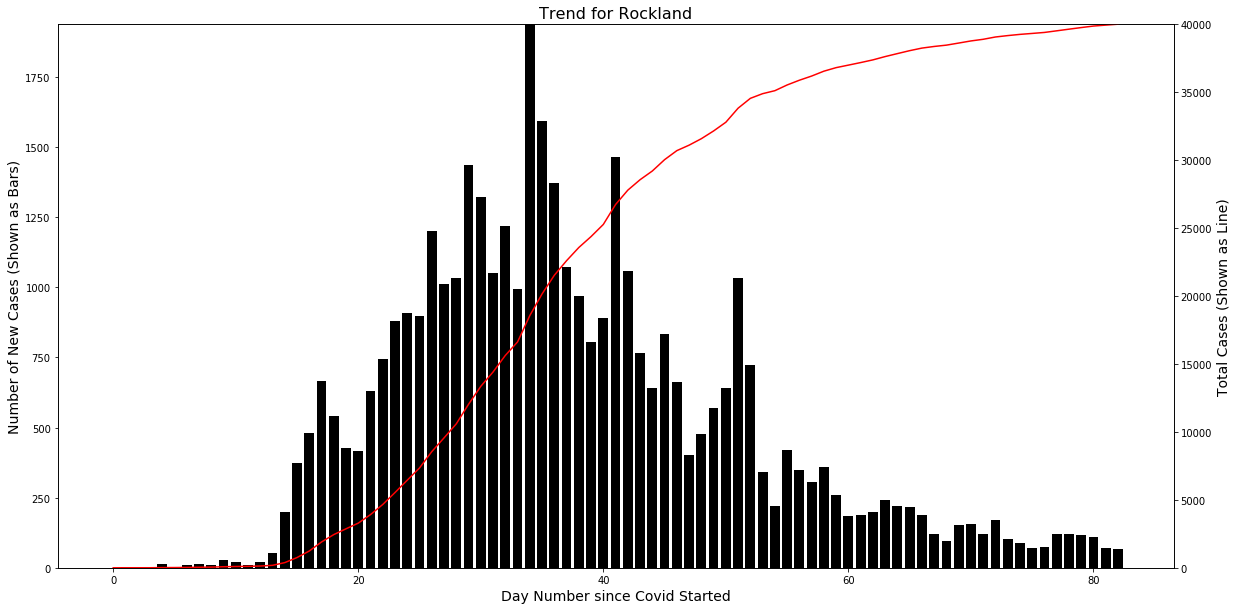

In [41]:
rockland_county = effected_counties_df[effected_counties_df['county'] == 'Rockland'].reset_index(drop=True)
rockland_county = rockland_county.sort_values(by='date').reset_index(drop=True)
rockland_county = rockland_county.set_index('date', drop=True)
rockland_county = rockland_county[['cases', 'new_day_cases']]

build_combo_chart(nassau_county, 'Rockland')

#### Trend Analysis for Rockland County shows that number of new cases being reported have decreased over past 30 days!

### Trends show that number of new cases has been dropping last 30 days in the most effected counties, so it is good to assume that these counties are safer, people can go back to normal, especially people in least effected counties!

In [42]:
body = client_04e417af96274891b2001e136606f42f.get_object(Bucket='ibmcapstoneproject-donotdelete-pr-9jmhti60s34ftn',Key='us_county_pop_and_shps.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

geography = pd.read_csv(body)
ny_geography = geography[geography['state'] == 'New York'].reset_index(drop=True)
ny_geography = ny_geography[['county', 'county_center_lat', 'county_center_lon']]

### Lockdown has been hard on all of us and we can't wait to get out there but, safety is still a concern hence we will curate list of safe activities in neighborhoods in NY

In [43]:
effected_county_loc = most_cases_counties[:5]
effected_county_loc = effected_county_loc.reset_index()
effected_county_loc = pd.merge(effected_county_loc, ny_geography, on='county', how='left')
effected_county_loc = effected_county_loc.rename(columns={'county_center_lat':'latitude', 'county_center_lon':'longitude'})
effected_county_loc = effected_county_loc.drop(columns=['cases'], axis=1)
effected_county_loc

,county,latitude,longitude
0,New York City,40.80,-73.95
1,Nassau,40.75,-73.59
2,Suffolk,40.87,-72.84
3,Westchester,41.17,-73.76
4,Rockland,41.15,-74.03


#### Setting up FourSquare API to explore Counties!

In [57]:
CLIENT_ID = 'AJT0XPXYB1RC4O34UNURB1LX2HMAGF4HV1QT2MWJDGWJ0SOS' # your Foursquare ID
CLIENT_SECRET = '0QSMS4JA3GYFRN305PGWQT0XKIGAM0VB5ON2TTPLRDELXABC' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 50
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AJT0XPXYB1RC4O34UNURB1LX2HMAGF4HV1QT2MWJDGWJ0SOS
CLIENT_SECRET:0QSMS4JA3GYFRN305PGWQT0XKIGAM0VB5ON2TTPLRDELXABC


In [74]:
def build_df(results):

    trend = pd.DataFrame(columns=['id', 'name', 'latitude', 'longitude', 'state', 'category_ids', 'category_names'])
    for itm in results:
        item = itm['venue']
        _id = item['id']
        _name = item['name']
        _lat = item['location']['lat']
        _long = item['location']['lng']
        _state = item['location']['state']
        _category_ids = []
        _category_names = []
        for category in item['categories']:
            _category_ids.append(category['id'])
            _category_names.append(category['name'])
        temp_df = pd.DataFrame(data={'id':[_id], 'name':[_name], 'latitude':[_lat], 'longitude':[_long], 'state':[_state], 'category_ids':[_category_ids], 'category_names':[_category_names]})    
        trend = trend.append(temp_df).reset_index(drop=True)

    return trend

In [75]:
def build_url(LAT, LONG):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, LAT,LONG,50000,LIMIT) 

#### Calling FourSquare API to get list of outdoor activities that are open for now that we can't wait to visit!

In [76]:
places_df = pd.DataFrame(columns=['id', 'name', 'latitude', 'longitude', 'state', 'category_ids', 'category_names'])
for index, col in effected_county_loc.iterrows():
    url = build_url(col['latitude'], col['longitude'])
    result = requests.get(url).json()
    r = result['response']['groups'][0]['items']
    tmp_df = build_df(r)
    places_df = places_df.append(tmp_df)
    
print('Places for all 5 counties are now put together in structured dataframe of shape ', places_df.shape)

Places for all 5 counties are now put together in structured dataframe of shape  (250, 7)


In [78]:
cleaned_places_df = places_df.copy()

In [79]:
cleaned_places_df = cleaned_places_df
cleaned_places_df['category_ids'] = cleaned_places_df['category_ids'].apply(lambda x: ', '.join(x))
cleaned_places_df['category_names'] = cleaned_places_df['category_names'].apply(lambda x: ', '.join(x))
cleaned_places_df.head()

,id,name,latitude,longitude,state,category_ids,category_names
0,56e86a57cd1017cb53f3e8f9,Sottocasa Pizzeria - Harlem,40.81,-73.95,NY,4bf58dd8d48988d1ca941735,Pizza Place
1,57083470498e3b4e7cfe6dbe,iLoveKickboxing,40.80,-73.95,NY,52f2ab2ebcbc57f1066b8b47,Boxing Gym
2,4d4f05ec9a2a6ea8dd5a286f,Levain Bakery,40.80,-73.96,NY,4bf58dd8d48988d16a941735,Bakery
3,4a9ad8d2f964a520213320e3,Conservatory Garden,40.79,-73.95,NY,4bf58dd8d48988d15a941735,Garden
4,4d2b4592d86aa0907fa322c0,Conservatory Garden Center Fountain,40.79,-73.95,NY,56aa371be4b08b9a8d573547,Fountain


In [80]:
cleaned_places_df.shape

(250, 7)

In [81]:
cleaned_places_df = cleaned_places_df.drop_duplicates()

In [85]:
cleaned_places_df.shape

(210, 7)

In [104]:
grouped_places_byname = cleaned_places_df[['category_names', 'name']].groupby(['category_names'])['name'].apply(lambda x: ', '.join(x)).reset_index()
grouped_places_byname = grouped_places_byname.set_index('category_names', drop=True)
grouped_places_byname.head()

,name
category_names,
American Restaurant,"The Alcove, The Cheesecake Factory, Parlor Hou..."
Arepa Restaurant,Arepera Guacuco Restaurant
Art Museum,The Metropolitan Museum of Art (Metropolitan M...
BBQ Joint,Fink's BBQ and Smokehouse
Bakery,"Levain Bakery, Levain Bakery, Levain Bakery, D..."


In [106]:
grouped_places_bycount = cleaned_places_df[['category_names', 'name']].groupby(['category_names'], as_index=False)['name'].count()
grouped_places_bycount = grouped_places_bycount.rename(columns={'name':'count'})
grouped_places_bycount = grouped_places_bycount.sort_values(by=['count'], ascending=False).reset_index(drop=True)
grouped_places_bycount = grouped_places_bycount.set_index('category_names', drop=True)
grouped_places_bycount.head()

,count
category_names,
Park,18
Pizza Place,9
Ice Cream Shop,9
Gym,8
Brewery,8


In [111]:
def get_places(category):
    return grouped_places_byname.loc[category]['name']

## Most important question now, Where do you wish to go ?

In [116]:
print('Choose from following categories:')
print(',  '.join(grouped_places_bycount.index.values.tolist()))

Choose from following categories:
Park,  Pizza Place,  Ice Cream Shop,  Gym,  Brewery,  Bakery,  Grocery Store,  Trail,  Garden,  American Restaurant,  Beach,  Italian Restaurant,  Scenic Lookout,  State / Provincial Park,  Sandwich Place,  Gym / Fitness Center,  Boxing Gym,  Mexican Restaurant,  Museum,  Bar,  Restaurant,  Supermarket,  Theater,  Café,  Wine Shop,  Seafood Restaurant,  Fountain,  Plaza,  New American Restaurant,  Surf Spot,  Japanese Restaurant,  Art Museum,  Indie Movie Theater,  Beer Bar,  Yoga Studio,  Deli / Bodega,  Concert Hall,  Cheese Shop,  Farmers Market,  Farm,  Coffee Shop,  Chinese Restaurant,  Cycle Studio,  Reservoir,  Convenience Store,  Community Center,  Sculpture Garden,  Cocktail Bar,  Church,  Tennis Stadium,  Sushi Restaurant,  Performing Arts Venue,  Thai Restaurant,  Track,  Caribbean Restaurant,  Vineyard,  Warehouse Store,  Waterfront,  Butcher,  BBQ Joint,  Food Truck,  Flea Market,  Outdoor Sculpture,  French Restaurant,  Botanical Garden, 

#### Do you wish to visit Parks ?

In [112]:
get_places('Park')

'Riverside Park, Central Park, Central Park West - W 86th St, Carl Schurz Park, Astoria Park, Riverside Park South, Central Park - Wien Walk, Manor Park, Kensico Dam Plaza, Pierson Park, Congers Lake Memorial Park, Waveny Park, Harbor Island Park, Untermyer Park, Greenwich Point Park, Van Cortlandt Park, Inwood Hill Park, Fort Tryon Park'

#### Do you wish to have some good Sushi ?

In [115]:
get_places('Sushi Restaurant')

'Onsen Sushi and Restaurant'

## Try it and let me know where you wish to visit!  Thank you for reviewing this code workbook.